# Ordering Kewords using Pretrained Embeddings

We use th FastText Bag Of Tricks model pretrained on **Common Crawl** and **Wikipedia** to generate the word embeddings. <br>
Link to the paper [here](https://arxiv.org/pdf/1607.01759.pdf). <br>
Link to the 157 pretrained embeddings [here](https://fasttext.cc/docs/en/crawl-vectors.html).

In [1]:
import fasttext
import fasttext.util
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score 
from Scripts.util import findAllIterationsInString
from IPython.display import clear_output
from sklearn.metrics.pairwise import cosine_distances

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Load the FastText Model

In [2]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('Models/cc.en.300.bin')

##### Load Data

In [3]:
labeled_concept_pair_df = pd.read_csv("Data/labeled_concept_pair_dataset.csv")
labeled_concept_pair_df.tail()

kw1                      kw2  label
25996  software testing debugging  combinational synthesis      0
25997     combinational synthesis         power management      0
25998    software fault tolerance        pcb design layout      0
25999           pcb design layout            formal method      0
26000               documentation        pcb design layout      0

In [4]:
kw_test = labeled_concept_pair_df.iloc[1,0]
print(kw_test)
embedding_dim = ft_model.get_word_vector(kw_test).shape[0]
print("Embedding size:", embedding_dim)

general reference
Embedding size: 300


In [5]:
ft_model.get_nearest_neighbors(kw_test)[:3]

[(0.613596498966217,
  'QQJCgAEACwJAAAAEAASAAAIZwABEBhIsKBBAQAEGiSQUCEBARAdDgQwoKJCiBEJUqw44CJGhxstDsSYkSFHhx8RahQ5MWFEhQ0TjiQZk6NIhB8b2uzIMKfOnQBoxgzJ82NLokVlakQqUOJSoAsnQo1q0qZTg0MHBgQAIfkECQoABAAsCQAAABAAEgAACGkAARAYSJAggIMEBSAsSADAgIcCCQiYGHGgw4cDIk6kaBBjxoEbFXaEmDBkxYsVNwJQiPCgS4sHKbr0'),
 (0.5904855728149414,
  'ČeskýDanskDeutschΕλληνικάEnglishEspañolFrançaisעבריתMagyarItaliano日本語한국어NederlandsPolskiPortuguêsРусскийSvenska中文'),
 (0.5851196646690369,
  'Bags.sizingInchesEURUSAUK8.50354.528.6335.552.58.88365.539.0036.563.59.13376.549.3837.574.59.50387.559.62538.585.59.875398.5610.004096.510.125419.5710.2542107.510.3754310.5810.5043.5118.510.6254411.5910.87544.5121011.004512.510.511.125461311')]

Okay, so it does not handle very well multiple word sentences, let's try doing the maxpooling ourselves:

In [6]:
## Average Pool Embedding
def avg_pool_embed(kw_list, embed_func):
    return np.mean([embed_func(part) for part in kw_list.split(" ")], axis = 0)
avg_embedding_test = avg_pool_embed(kw_test, ft_model.get_word_vector)
avg_embedding_test.shape

(300,)

In [10]:
## We can see that sentence_vector is very close to our average pooling method.
cosine_distances([ft_model.get_sentence_vector(kw_test)], [avg_embedding_test])[0,0]

0.0024307966

In [11]:
## Average Pool Embeddings for kw1 and kw2
# temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: (avg_pool_embed(x.kw1, ft_model.get_word_vector), avg_pool_embed(x.kw2, ft_model.get_word_vector)), axis=1, result_type='expand'))
# labeled_concept_pair_df[["avg_pool_embedding_1", "avg_pool_embedding_2"]] = temp_res

Sentence Vector Explained [here](https://stackoverflow.com/questions/54181163/fasttext-embeddings-sentence-vectors). In sum, they normalize their vectors before computing the average ;).

In [12]:
## Average Pool Embeddings for kw1 and kw2
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: (ft_model.get_sentence_vector(x.kw1), ft_model.get_sentence_vector(x.kw2)), axis=1, result_type='expand'))
labeled_concept_pair_df[["sentence_vector_embedding_1", "sentence_vector_embedding_2"]] = temp_res

In [13]:
labeled_concept_pair_df.tail()

kw1                      kw2  label  \
25996  software testing debugging  combinational synthesis      0   
25997     combinational synthesis         power management      0   
25998    software fault tolerance        pcb design layout      0   
25999           pcb design layout            formal method      0   
26000               documentation        pcb design layout      0   

                             sentence_vector_embedding_1  \
25996  [0.029621912, -0.008412714, 0.03842728, 0.0606...   
25997  [0.08096917, 0.030264342, 0.04064402, 0.016720...   
25998  [0.011055365, 0.043711685, -0.021244038, 0.046...   
25999  [0.07769436, -0.01909836, 0.050779857, 0.05521...   
26000  [0.0409104, 0.0708428, 0.033104822, 0.05937038...   

                             sentence_vector_embedding_2  
25996  [0.08096917, 0.030264342, 0.04064402, 0.016720...  
25997  [-0.07305679, 0.037602574, 0.10327606, 0.03084...  
25998  [0.07769436, -0.01909836, 0.050779857, 0.05521...  
25999  [0.028043732, -0.0068222457, 0.0077669974, 0.0...  
26000  [0.07769436, -0.01909836, 0.050779857, 0.05521...

In [15]:
cos_mat_1 = cosine_distances(np.array([np.array(el) for el in labeled_concept_pair_df.iloc[:,4]]))
# cos_mat_2 = cosine_distances(np.array([np.array(el) for el in labeled_concept_pair_df.iloc[:,6]]))

In [28]:
# most_similar_kw = labeled_concept_pair_df.iloc[np.argsort(cos_mat_1[0]), 1]
# print("Word being analyzed:", labeled_concept_pair_df.iloc[0,1])
# set(most_similar_kw[:100])

Word being analyzed: general reference


{'context specific language',
 'general conference proceeding',
 'general literature',
 'general programming language',
 'general reference'}

##### Results of average pooling only embeddings
Word being analyzed: general reference <br>
{'context specific language', <br>
 'general conference proceeding', <br>
 'general literature', <br>
 'general programming language', <br>
 'general reference'} <br>

In [16]:
most_similar_kw = labeled_concept_pair_df.iloc[np.argsort(cos_mat_1[0]), 1]
print("Word being analyzed:", labeled_concept_pair_df.iloc[0,1])
set(most_similar_kw[:100])

Word being analyzed: general reference


{'general conference proceeding',
 'general literature',
 'general programming language',
 'general reference',
 'reference model',
 'reference work'}

In [17]:
## Delete cos matrix to Free some RAM
del cos_mat_1
cos_mat_1 = None

Better similarity results in the second case

#### Create Labeled Data

In [33]:
def entropy(distrib):
    """Function that computes the Entropy of a probability distribution p(x):
       -sum over x of p(x) * log(p(x))
    """
    eps = 1e-12
    distrib = np.abs(distrib) / np.linalg.norm(distrib, ord=2)
    return -np.sum(distrib * np.log(distrib + eps))


def kl_div(x, y):
    """Function that computes the kl divergence of two discrete distributions"""
    idx1 = np.intersect1d(np.where(x>0), np.where(y>0))
    idx2 = np.where(x==0)

    return (x[idx1]*np.log(x[idx1]/y[idx1])).sum() + y[idx2].sum()

def MutualInfoEmbed(kw1_embed, kw2_embed):
    kw1_embed = np.abs(kw1_embed) / np.linalg.norm(kw1_embed, ord=2)
    kw2_embed = np.abs(kw2_embed) / np.linalg.norm(kw2_embed, ord=2)

    return mutual_info_score(kw1_embed, kw2_embed) 

def ComputeMetricsForKeywordPair(kw1_embed, kw2_embed, verbose=False):
    H1_var = entropy(kw1_embed)
    H2_var = entropy(kw2_embed)
    kl_div1 = kl_div(kw1_embed, kw2_embed).sum()
    kl_div2 = kl_div(kw2_embed, kw1_embed).sum()
    ratio   = kl_div1/kl_div2 if kl_div2 != 0 else np.nan
    MI_var  = MutualInfoEmbed(kw1_embed, kw2_embed)

    if(verbose):
        print("Entropy for kw1:", H1_var)
        print("Entropy for kw2:", H2_var)
    # else:
    #     clear_output(wait=True)

    return (H1_var, H2_var, kl_div1, kl_div2, ratio, MI_var)

Test of new implementation

In [34]:
kw1_embed_test = labeled_concept_pair_df.iloc[0,3]
kw2_embed_test = labeled_concept_pair_df.iloc[0,4]

ComputeMetricsForKeywordPair(kw1_embed_test, kw2_embed_test, verbose=False)

/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


(39.034508, 38.476612, 1.1832626, 2.3239477, 0.5091606, 5.703782474656201)

##### Add the metrics to the labeled data

In [35]:
## Compute the metrics on both embeddings
temp_res = pd.DataFrame(labeled_concept_pair_df.apply(lambda x: ComputeMetricsForKeywordPair(x.sentence_vector_embedding_1, x.sentence_vector_embedding_2), axis=1, result_type='expand'))
labeled_concept_pair_df[["H1", "H2", "DKL_1", "DKL_2", "ratio", "MI"]] = temp_res
labeled_concept_pair_df.tail()

/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and con

kw1                      kw2  label  \
25996  software testing debugging  combinational synthesis      0   
25997     combinational synthesis         power management      0   
25998    software fault tolerance        pcb design layout      0   
25999           pcb design layout            formal method      0   
26000               documentation        pcb design layout      0   

                             sentence_vector_embedding_1  \
25996  [0.029621912, -0.008412714, 0.03842728, 0.0606...   
25997  [0.08096917, 0.030264342, 0.04064402, 0.016720...   
25998  [0.011055365, 0.043711685, -0.021244038, 0.046...   
25999  [0.07769436, -0.01909836, 0.050779857, 0.05521...   
26000  [0.0409104, 0.0708428, 0.033104822, 0.05937038...   

                             sentence_vector_embedding_2         H1  \
25996  [0.08096917, 0.030264342, 0.04064402, 0.016720...  37.156647   
25997  [-0.07305679, 0.037602574, 0.10327606, 0.03084...  37.081490   
25998  [0.07769436, -0.01909836, 0.050779857, 0.05521...  38.956970   
25999  [0.028043732, -0.0068222457, 0.0077669974, 0.0...  38.210690   
26000  [0.07769436, -0.01909836, 0.050779857, 0.05521...  39.183540   

              H2     DKL_1     DKL_2     ratio        MI  
25996  37.081490  1.552294  2.624489  0.591465  5.703782  
25997  37.063046  2.216187  2.084408  1.063221  5.703782  
25998  38.210690  1.021911  1.735700  0.588760  5.703782  
25999  37.955505  1.212825  1.930712  0.628175  5.703782  
26000  38.210690  3.692428  0.580360  6.362306  5.703782

In [36]:
labeled_concept_pair_df.describe()

label            H1            H2         DKL_1         DKL_2  \
count  26001.000000  26001.000000  26001.000000  26001.000000  26001.000000   
mean       0.000462     38.051951     38.043107      1.907285      1.898323   
std        0.479583      0.723921      0.723995      0.980559      0.981189   
min       -1.000000     34.918709     34.918709     -0.693059     -0.612167   
25%        0.000000     37.570026     37.556023      1.227859      1.213816   
50%        0.000000     38.074333     38.071796      1.777231      1.768360   
75%        0.000000     38.518829     38.518639      2.437613      2.433226   
max        1.000000     40.916695     40.916695      7.467324      7.349680   

              ratio            MI  
count  26001.000000  26001.000000  
mean       1.922355      5.703771  
std      105.258685      0.000233  
min   -13943.749023      5.699161  
25%        0.524312      5.703782  
50%        0.993644      5.703782  
75%        1.848946      5.703782  
max     4297.793457      5.703782

### Gradient Boosting

#### Complete classification task with -1, 0, 1 labels

##### Only using embeddings

In [68]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2", 'H1', 'H2', 'DKL_1', 'DKL_2', 'ratio',
       'MI'])#.dropna(subset="ratio")

training_data_embedding = processed_data.drop(columns="label").iloc[:,0:2]

array_1, array_2 = training_data_embedding.to_numpy()[:,0], training_data_embedding.to_numpy()[:,1]

array_1 = np.array([np.array(el) for el in array_1])
array_2 = np.array([np.array(el) for el in array_2])

training_data_embedding = np.concatenate((array_1, array_2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(training_data_embedding, processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [70]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [71]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.9058412907111375

In [21]:
best_model = gsearch1.best_estimator_

In [22]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [23]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [73]:
best_model = gsearch1.best_estimator_
y_pred=best_model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [74]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9131


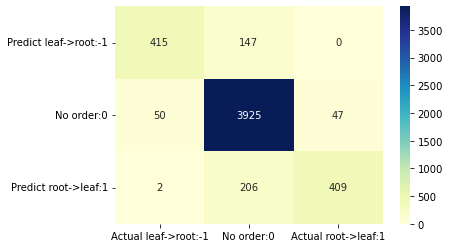

In [79]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.89      0.74      0.81       562
           0       0.92      0.98      0.95      4022
           1       0.90      0.66      0.76       617

    accuracy                           0.91      5201
   macro avg       0.90      0.79      0.84      5201
weighted avg       0.91      0.91      0.91      5201



##### Only using Metrics

In [80]:
processed_data = labeled_concept_pair_df.drop(columns=["kw1", "kw2", 'sentence_vector_embedding_1', 'sentence_vector_embedding_2']).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns=["label"]), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [81]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [82]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8113701739724755

In [83]:
best_model = gsearch1.best_estimator_

In [84]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [85]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [86]:
y_pred=best_model.predict(X_test)
y_pred

array([ 1,  0, -1, ...,  1,  0,  0])

In [87]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8410


Text(0, 0.5, 'Feature Importance Score')

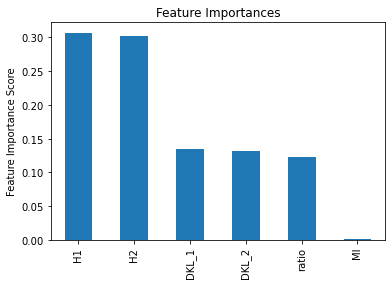

In [92]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Observations des variables importantes beaucoup plus cohérentes avec l'asymétrie requise pour comprendre la relation d'ordre. D_KL + Entropie sont utiles.

Plot confusion matrix

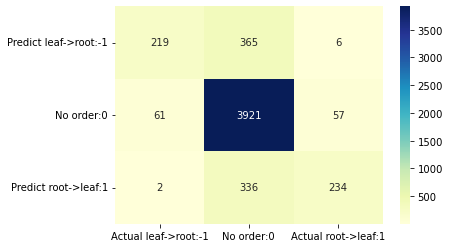

In [88]:
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:-1', 'No order:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:-1', 'No order:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.37      0.50       590
           0       0.85      0.97      0.91      4039
           1       0.79      0.41      0.54       572

    accuracy                           0.84      5201
   macro avg       0.80      0.58      0.65      5201
weighted avg       0.83      0.84      0.82      5201



Perte de performance avec cette reduction de dimension grâce aux metriques de l'information mutuelle.<br>
Mon hypothèse est qu'avec des plongements probabiliste comme GLoVe, ces métriques là marcheraient mieux. L'idéal serait d'avoir une métrique de cooccurence comme GLoVe, mais qui produisent des embeddings pour des mots qui ne sont pas dans le vocabulaire comme FastText.

#### Ony on -1 and 1 labels

In [90]:
labeled_minus1_1_concept_pair_df = labeled_concept_pair_df[labeled_concept_pair_df.label.isin([-1,1])]
labeled_minus1_1_concept_pair_df.describe()

label           H1           H2        DKL_1        DKL_2  \
count  5980.000000  5980.000000  5980.000000  5980.000000  5980.000000   
mean      0.002007    38.056922    38.059235     1.810620     1.822094   
std       1.000082     0.688050     0.695169     0.998936     0.983428   
min      -1.000000    34.918709    34.918709    -0.693059    -0.612167   
25%      -1.000000    37.556057    37.574461     1.125898     1.161573   
50%       1.000000    38.094734    38.109169     1.696963     1.707899   
75%       1.000000    38.484402    38.510300     2.345442     2.390277   
max       1.000000    40.916695    40.916695     7.356508     6.596412   

             ratio           MI  
count  5980.000000  5980.000000  
mean      2.544752     5.703776  
std      74.465800     0.000169  
min   -1397.885742     5.699161  
25%       0.475476     5.703782  
50%       0.958800     5.703782  
75%       1.825314     5.703782  
max    3838.865723     5.703782

##### Only using Metrics

In [91]:
processed_data = labeled_minus1_1_concept_pair_df.drop(columns=["kw1", "kw2", 'sentence_vector_embedding_1', 'sentence_vector_embedding_2']).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns=["label"]), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [93]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [94]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.8068248181920745

In [95]:
best_model = gsearch1.best_estimator_

In [96]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [97]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [98]:
y_pred=best_model.predict(X_test)
y_pred

array([-1, -1,  1, ..., -1, -1,  1])

In [99]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8311


Text(0, 0.5, 'Feature Importance Score')

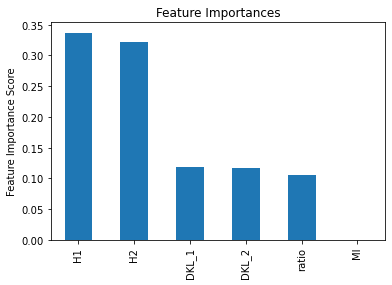

In [100]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

<AxesSubplot:>

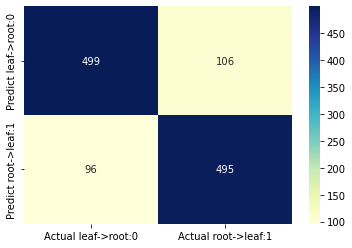

In [101]:
cm = confusion_matrix(y_test, y_pred)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.82      0.83       605
           1       0.82      0.84      0.83       591

    accuracy                           0.83      1196
   macro avg       0.83      0.83      0.83      1196
weighted avg       0.83      0.83      0.83      1196



##### Save Models

In [31]:
pickle.dump(best_model, open("Models/naive_gridsearch.pkl", "wb"))

In [23]:
best_model = pickle.load(open("Models/naive_gridsearch.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)